[View in Colaboratory](https://colab.research.google.com/github/KGalik/image-generation/blob/master/ImageGenerationAutoencoder.ipynb)

###Import the pretrained autoencoder and its weights

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving decoder.h5 to decoder.h5
Saving decoder.json to decoder.json
Saving encoder.h5 to encoder.h5
Saving encoder.json to encoder.json
Saving autoencoder.h5 to autoencoder.h5
Saving autoencoder.json to autoencoder.json
User uploaded file "decoder.h5" with length 2330624 bytes
User uploaded file "decoder.json" with length 3030 bytes
User uploaded file "encoder.h5" with length 2326384 bytes
User uploaded file "encoder.json" with length 3027 bytes
User uploaded file "autoencoder.h5" with length 4650896 bytes
User uploaded file "autoencoder.json" with length 5694 bytes


In [2]:
from keras.models import model_from_json 
  
 # load json and create model: autoencoder
json_file = open('autoencoder.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
autoencoder = model_from_json(loaded_model_json)
# load weights into new model
autoencoder.load_weights("autoencoder.h5")
print("Loaded autoencoder from disk")

 # load json and create model: encoder
json_file = open('encoder.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
encoder = model_from_json(loaded_model_json)
# load weights into new model
encoder.load_weights("encoder.h5")
print("Loaded encoder from disk")

 # load json and create model: decoder
json_file = open('decoder.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
decoder = model_from_json(loaded_model_json)
# load weights into new model
decoder.load_weights("decoder.h5")
print("Loaded model from disk")
 
# # evaluate loaded model on test data
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
print("NNs are ready to use")

Using TensorFlow backend.


Loaded autoencoder from disk
Loaded encoder from disk
Loaded model from disk
NNs are ready to use


### Retrieve and encode MNIST data

11493376/11490434 [==============================] - 1s 0us/step


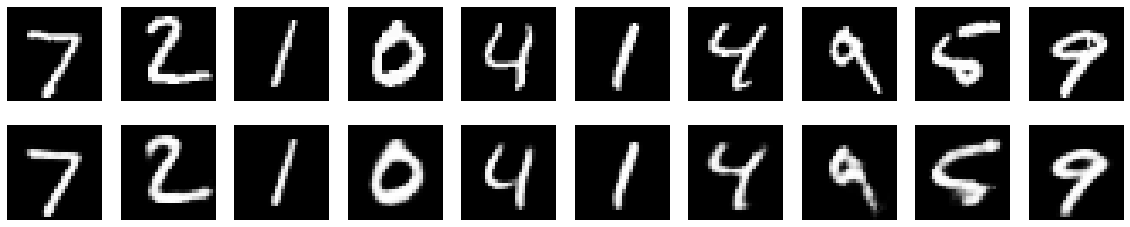

In [3]:
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
import numpy as np
(x_train, train_labels), (x_test, test_labels) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Generate digits from a single Gaussian distribution

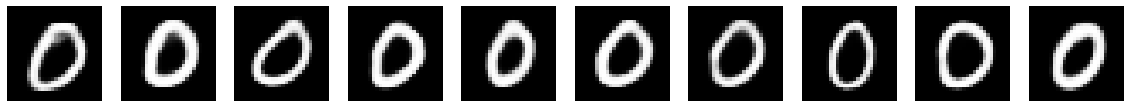

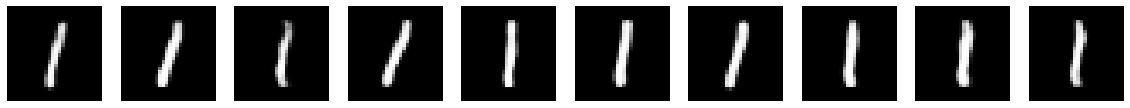

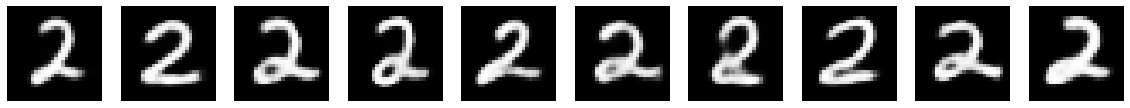

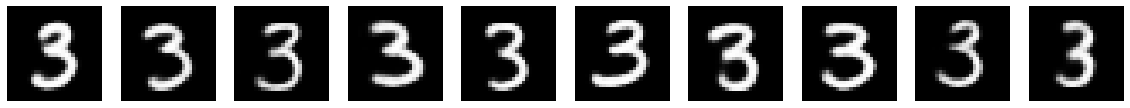

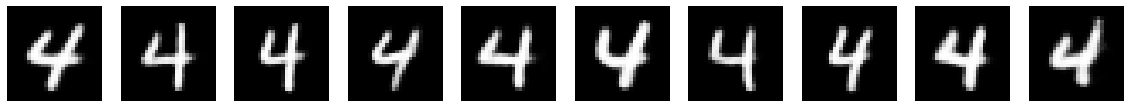

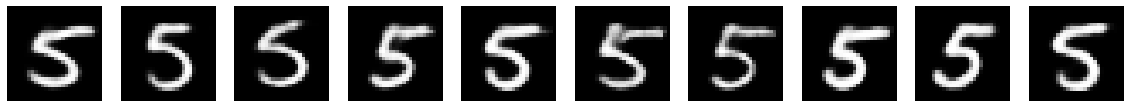

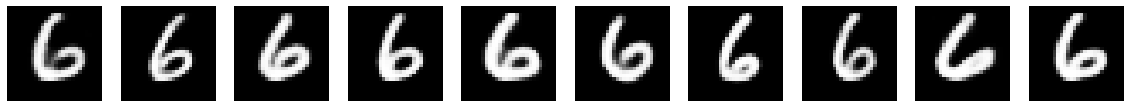

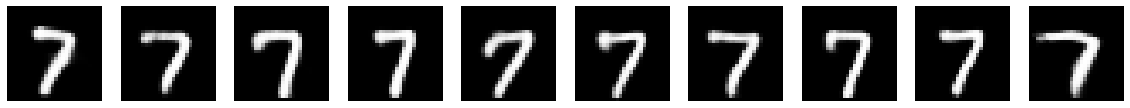

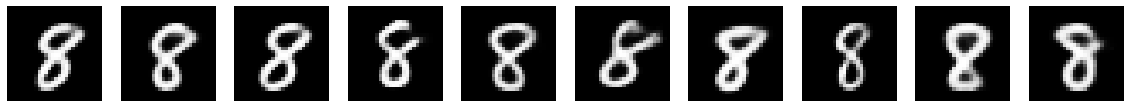

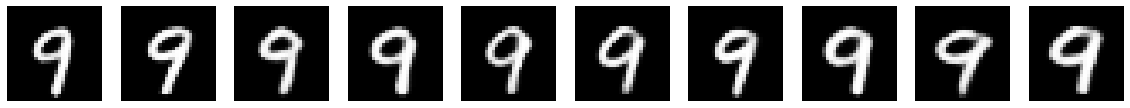

In [4]:
def get_gaussians(data, labels):
    m, n = data.shape
    if n == 0 or m == 0 or len(labels) != m:
        return None
    cov = np.zeros((10, n, n), dtype=float)
    means = np.zeros((10, n), dtype=float)
    counts = np.zeros(10, dtype=int)


    for i in range(m):
        j = labels[i]
        counts[j] +=1
        means[j] += data[i]
    for k in range(10):
        if counts[k] == 0:
            counts[k] = 1
        means[k] /= counts[k]
    for i in range(m):
        j = labels[i]
        cov[j] += np.outer(data[i]-means[j], (data[i].T-means[j].T))
    for k in range(10):
        cov[k] /= counts[k]
    return means, cov
  
means, covs = get_gaussians(encoded_imgs,test_labels)
n = 10

for i in range(10):
  new_encoded_imgs = np.random.multivariate_normal(means[i],0.2*covs[i],10)
  decoded_imgs = decoder.predict(new_encoded_imgs)
  plt.figure(figsize=(20, 4))
  for i in range(n):

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

### Generate digits from Gaussian mixtures

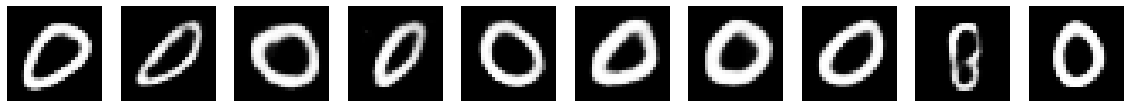

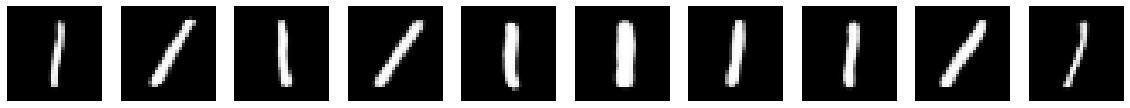

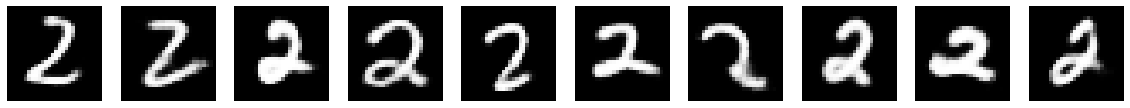

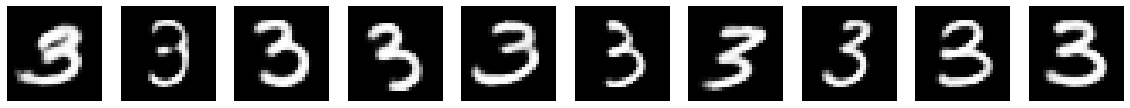

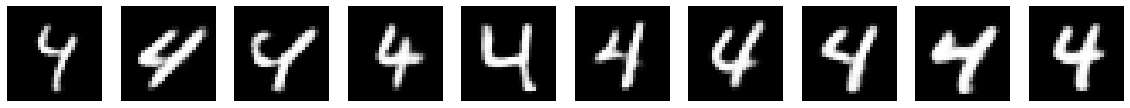

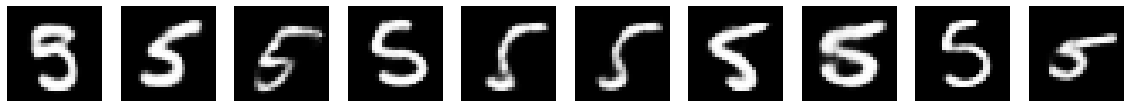

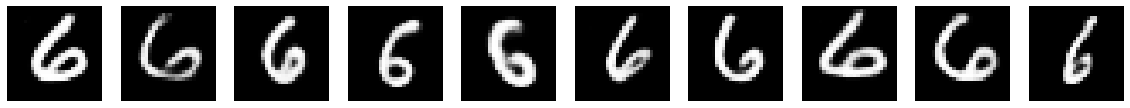

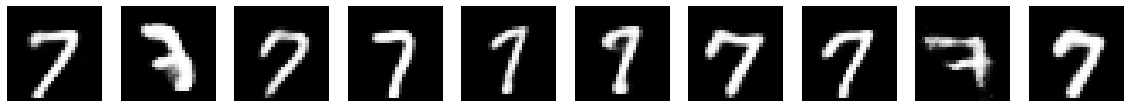

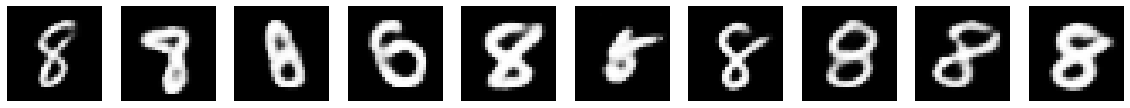

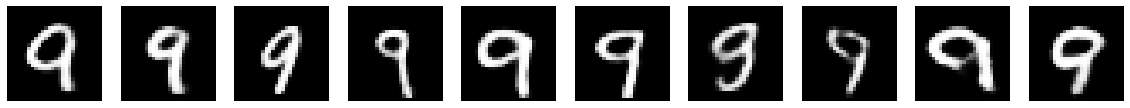

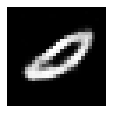

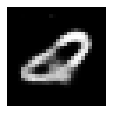

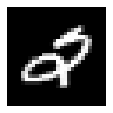

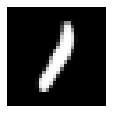

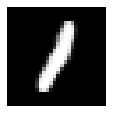

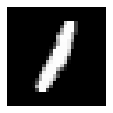

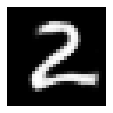

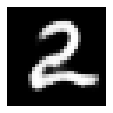

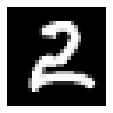

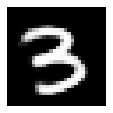

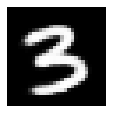

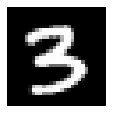

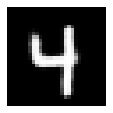

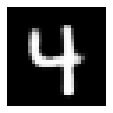

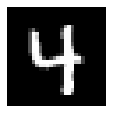

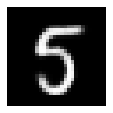

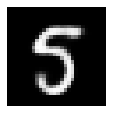

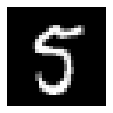

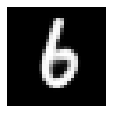

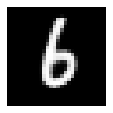

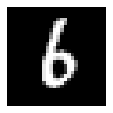

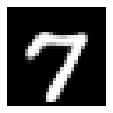

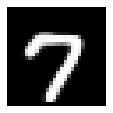

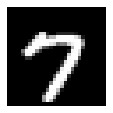

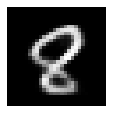

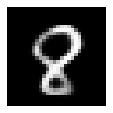

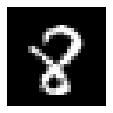

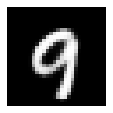

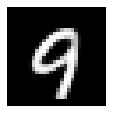

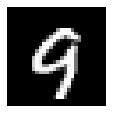

In [5]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import log_loss

def CrossEntropy(y_true, y_pred):
  return -((y_true*np.log(y_pred))+((1-y_true)*np.log(1-y_pred)))
    
def binarycrossentropy(y_true,y_pred):
  loss = 0.0
  for i,_ in enumerate(y_true):
    loss += CrossEntropy(y_true[i],y_pred[i])
  return loss

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

#split the data
encoded_classified_dict={}
for i in range(10):
  ind=np.reshape(np.argwhere(test_labels==i),(np.argwhere(test_labels==i).shape[0]))
  encoded_classified_dict['{}'.format(i)]=encoded_imgs[ind,:]

n=10
for k in range(10):
  for j in range(125,126):
    clf = GaussianMixture(n_components=j,max_iter=1000,init_params="kmeans")
    clf.fit(encoded_classified_dict[str(k)])
    new_encoded_imgs,_ = clf.sample(n)
    new_decoded_imgs = decoder.predict(new_encoded_imgs)
    plt.figure(figsize=(20, 4))
    for i in range(n):
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(new_decoded_imgs[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
    plt.show()

n=1
for k in range(10):
  for j in range(125,126):
    clf = GaussianMixture(n_components=j,max_iter=1000,init_params="kmeans")
    clf.fit(encoded_classified_dict[str(k)])
    new_encoded_imgs,_ = clf.sample(n)
    new_decoded_imgs = decoder.predict(new_encoded_imgs)
    plt.figure(figsize=(20, 4))
    for i in range(n):
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(new_decoded_imgs[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
    plt.show()
    plt.figure(figsize=(20, 4))
    for i in range(1):
      generated_digit = new_decoded_imgs[i]
      best_match = decoded_imgs[0]
      best_score = binarycrossentropy(generated_digit,best_match)
      best_ind = 0
      for l,digit in enumerate(decoded_imgs):
        current_score = binarycrossentropy(generated_digit,digit)
        if current_score < best_score:
          best_match = digit
          best_score = current_score
          best_ind = l
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(best_match.reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.show()
      plt.figure(figsize=(20, 4))
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(x_test[best_ind].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.show()

# Standard basis vectors

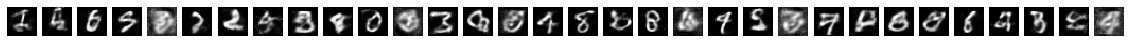

In [6]:
n=32
new_encoded_imgs = 10*np.identity(32)
decoded_imgs = decoder.predict(new_encoded_imgs)
plt.figure(figsize=(20, 4))
for i in range(n):
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Sparse means

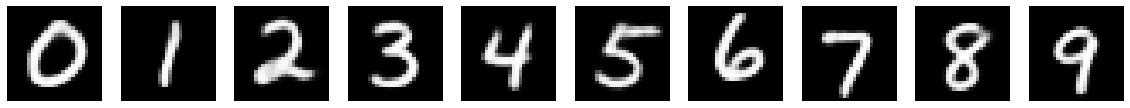

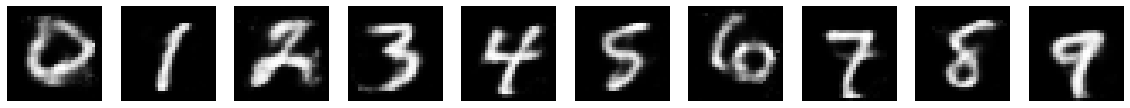

In [7]:
nonzeros = 2 # 0 to 31
sparse_means = means.copy()
for i, mu in enumerate(means):
  m = sorted(mu,reverse=True)
  for j, val in enumerate(mu):
    if m[nonzeros] > val:
      sparse_means[i][j] = 0

n=10
new_encoded_imgs = means
decoded_imgs = decoder.predict(new_encoded_imgs)
plt.figure(figsize=(20, 4))
for i in range(10):
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

n=10
new_encoded_imgs = sparse_means
decoded_imgs = decoder.predict(new_encoded_imgs)
plt.figure(figsize=(20, 4))
for i in range(10):
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Convex combinations of sample means

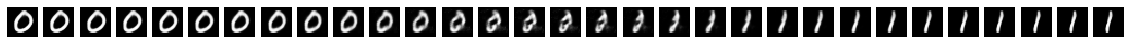

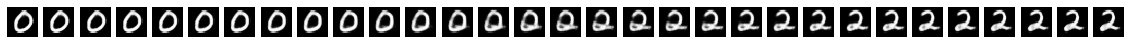

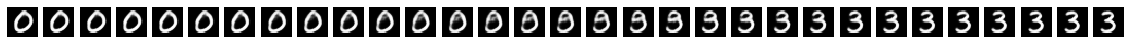

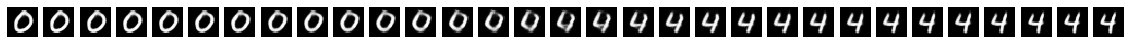

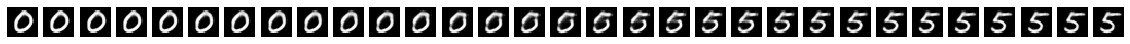

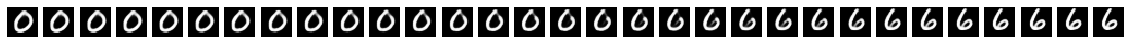

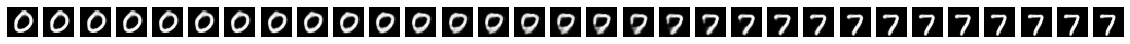

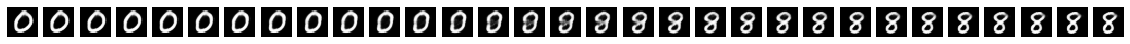

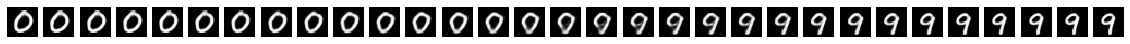

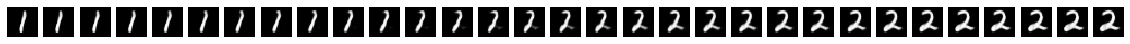

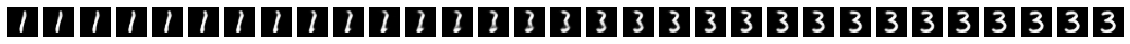

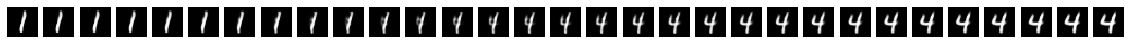

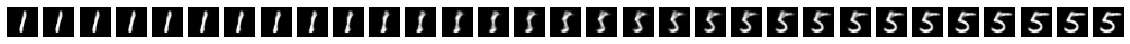

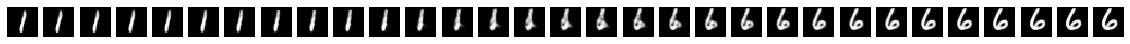

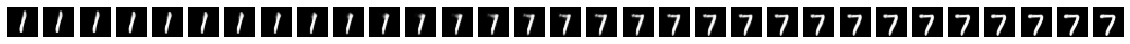

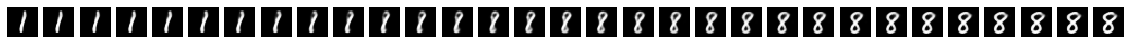

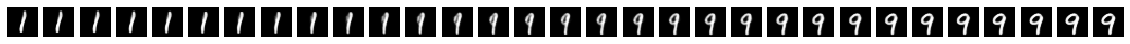

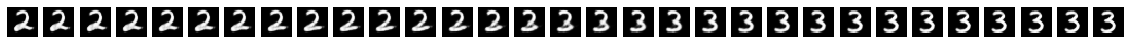

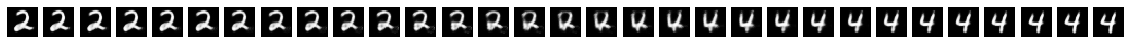

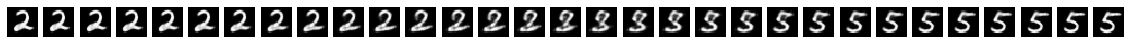

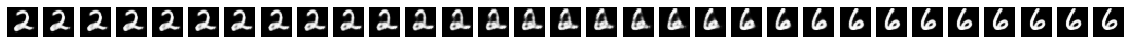

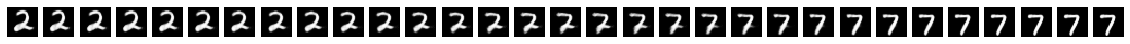

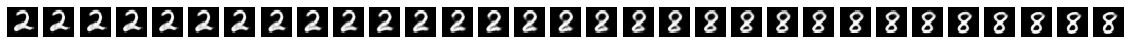

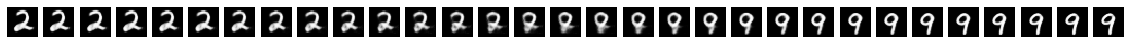

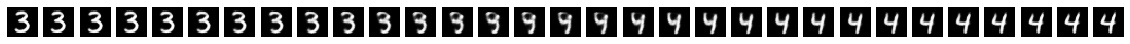

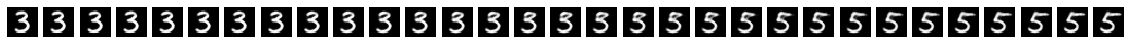

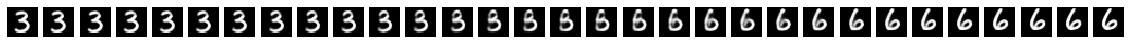

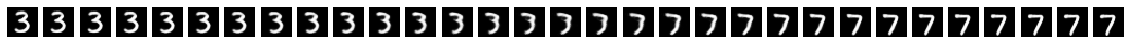

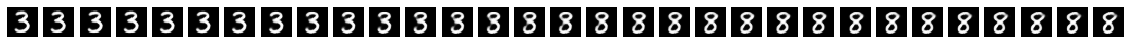

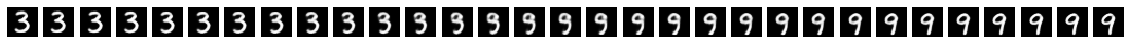

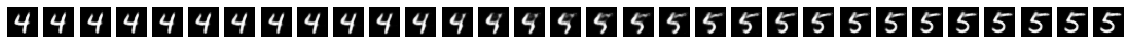

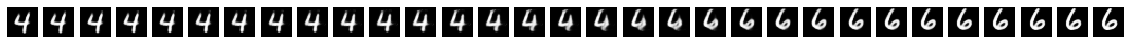

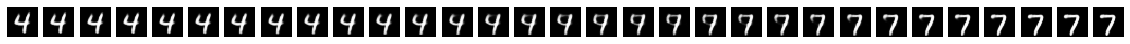

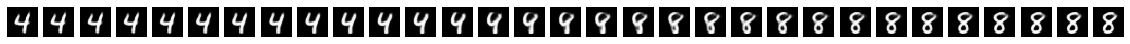

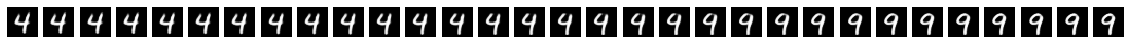

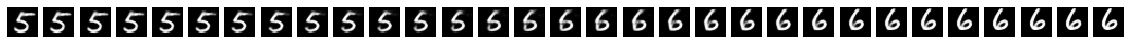

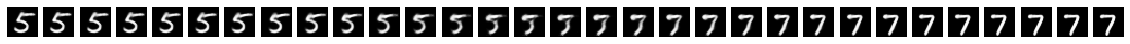

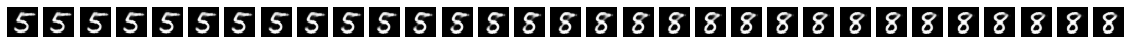

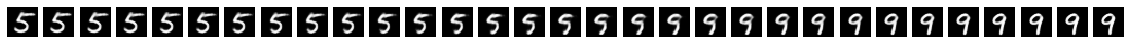

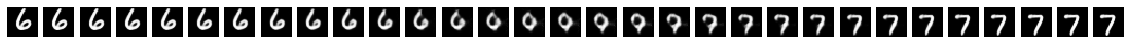

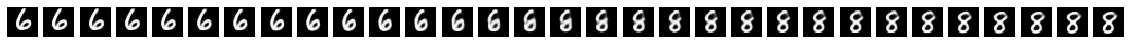

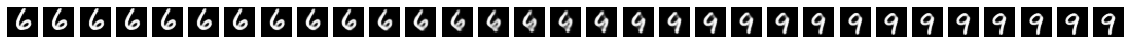

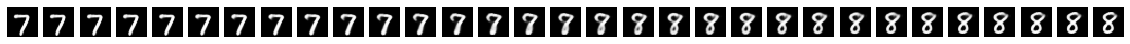

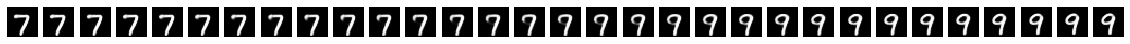

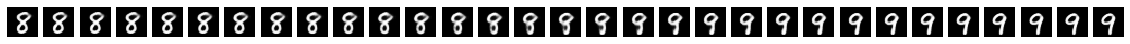

In [8]:
for i in range(10):
  for j in range(i+1,10):
    n=31
    new_encoded_imgs = np.mat([(((float(n-1)-a)/float(n-1))*means[i])+((a/float(n-1))*means[j]) for a in range(n)])
    decoded_imgs = decoder.predict(new_encoded_imgs)
    plt.figure(figsize=(20, 4))
    for k in range(n):
      ax = plt.subplot(2, n, k + 1 + n)
      plt.imshow(decoded_imgs[k].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
    plt.show()

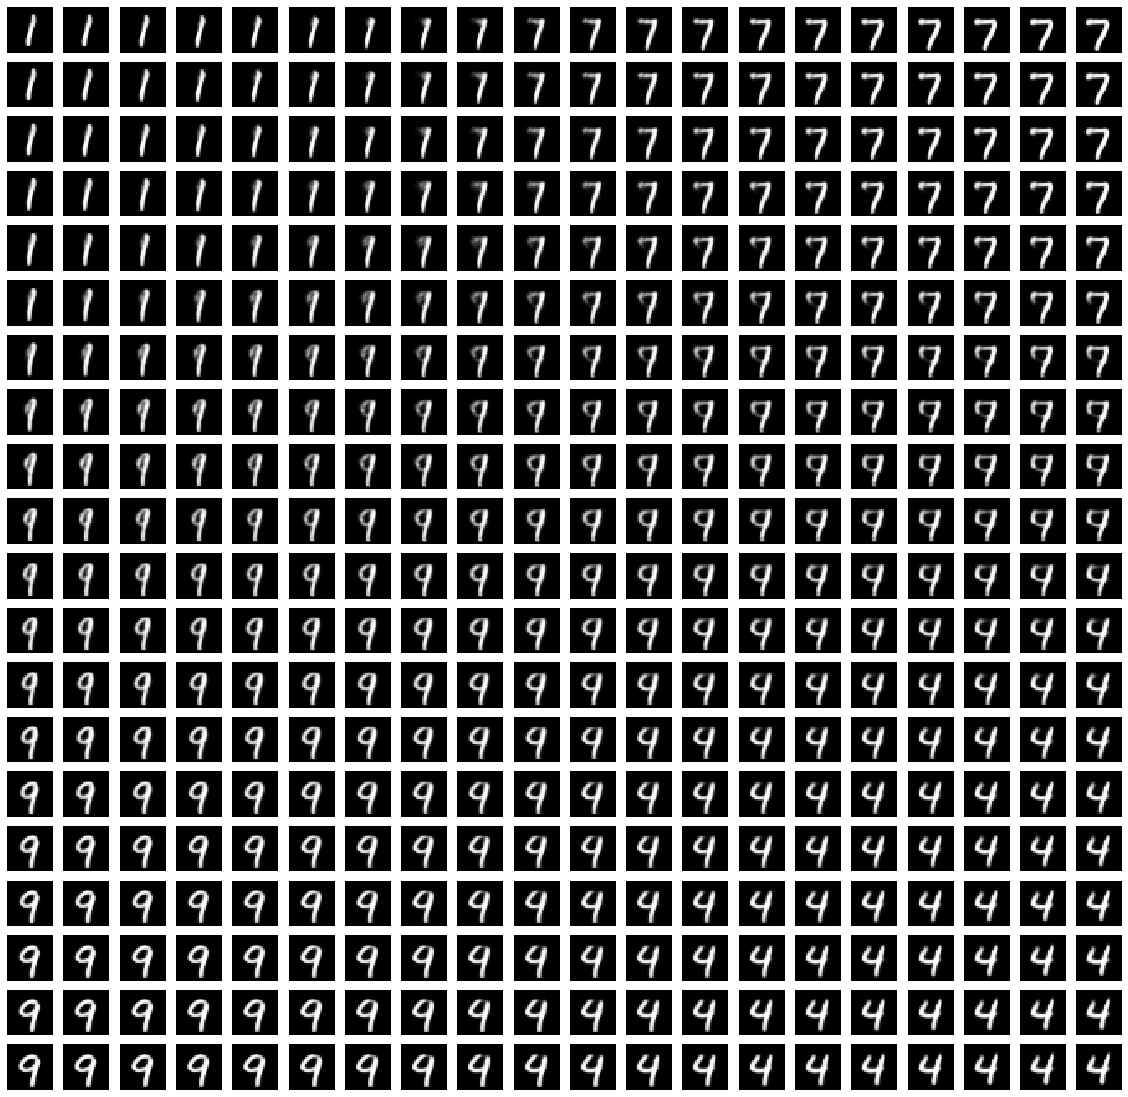

In [9]:
i,j,k,l = 1,7,9,4
n=20
alphavecs1 = [(((float(n-1)-a)/float(n-1))*means[i])+((a/float(n-1))*means[k]) for a in range(n)]
alphavecs2 = [(((float(n-1)-a)/float(n-1))*means[j])+((a/float(n-1))*means[l]) for a in range(n)]
new_encoded_imgs = np.mat([(((float(n-1)-a)/float(n-1))*alphavecs1[0])+((a/float(n-1))*alphavecs2[0]) for a in range(n)])
for b in range(1,n):
  new_encoded_imgs = np.append(new_encoded_imgs,[(((float(n-1)-a)/float(n-1))*alphavecs1[b])+((a/float(n-1))*alphavecs2[b]) for a in range(n)],axis=0)
decoded_imgs = decoder.predict(new_encoded_imgs)
plt.figure(figsize=(20, 40))
for k in range(n**2):
  ax = plt.subplot(2*n, n, k + 1 + n)
  plt.imshow(decoded_imgs[k].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# PCA

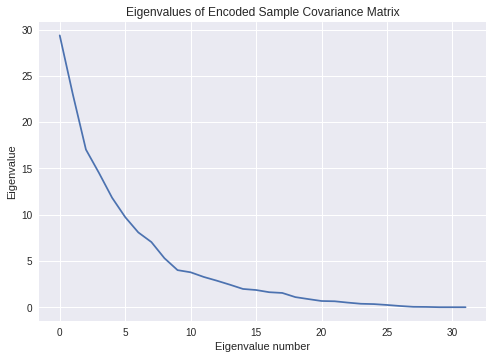

In [10]:
encodedcovmat = np.cov(encoded_imgs.T)
vals, vecs = np.linalg.eig(encodedcovmat)
idx = vals.argsort()[::-1]
vals = vals[idx]
vecs = vecs[:,idx]
plt.plot(range(len(vals)), vals)
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of Encoded Sample Covariance Matrix")
plt.show()

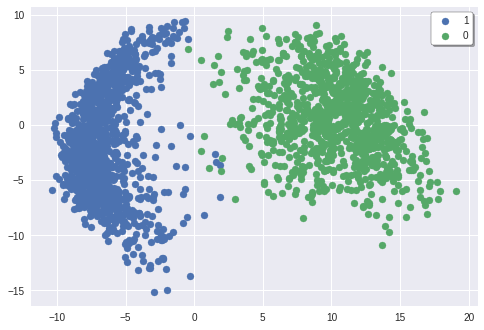

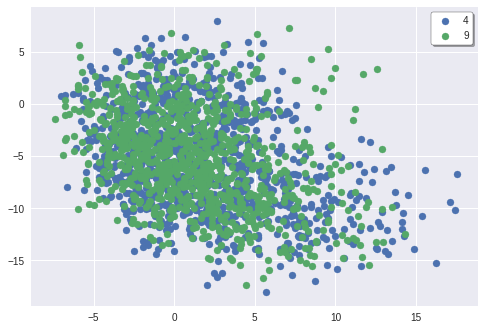

In [11]:
testlists = [[1,0],[4,9]]
for testlist in testlists:
  for i in testlist:
    u1 = []
    u2 = []
    X = encoded_classified_dict[str(i)].T
    for j in range(X.shape[1]):
      u1.append(np.matmul(vecs[:,0],X[:,j]))
      u2.append(np.matmul(vecs[:,1],X[:,j]))
    plt.scatter(u1,u2,label=str(i))
  plt.legend(loc="best",frameon=True,shadow=True,facecolor="w",edgecolor=(0,0,0))
  plt.show()